In [1]:
### install packages
import pandas as pd
import numpy as np
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder, StandardScaler
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.metrics import (
    roc_curve,
    accuracy_score,
    f1_score,
    fbeta_score,
    recall_score,
    precision_score,
    auc,
)
from sklearn.pipeline import Pipeline, make_pipeline
import matplotlib.pyplot as plt
import logging
import pickle
import os

%matplotlib inline

In [2]:
logging.basicConfig(level=logging.INFO, format="%(asctime)-15s %(message)s")
logger = logging.getLogger()

In [3]:
def import_data(pth):
    """
    Imports data from the provided path and cleans the column names and categorical features.

    Inputs
    ------
    pth : str
        Path to the dataset file (CSV or other format supported by pandas).

    Returns
    -------
    X : pd.DataFrame
        Cleaned data with stripped column names and categorical features.
    """

    # Load the dataset from the given path
    logger.info("Downloading data set")
    X = pd.read_csv(pth)

    # Strip column names
    X.columns = X.columns.str.strip()

    return X

In [4]:
X = import_data(pth="/Users/ruilu/nd0821-c3-starter-code/starter/data/census.csv")

2024-12-29 13:01:05,354 Downloading data set


In [5]:
def process_data(X, categorical_features=[], label=None):
    """Process the data used in the machine learning pipeline.

    Processes the data by stripping spaces from categorical features and optionally
    separates out the label if provided. This function can be used for both training and
    inference/validation.

    Parameters
    ----------
    X : pd.DataFrame
        DataFrame containing the features and label.
    categorical_features : list of str, optional, default=[]
        List containing the names of the categorical features.
        Will strip spaces and ensure they are in string format.
    label : str or None, optional, default=None
        Name of the label column in X. If None, the function will return an empty DataFrame for y.

    Returns
    -------
    X_processed : pd.DataFrame
        Processed feature data (categorical features stripped of spaces).
    y : pd.Series or None
        Processed label data as a pandas Series, or None if label is None.
    """

    # Handle categorical features: strip spaces and convert to strings
    logger.info("Handle categorical features")
    if categorical_features:
        for col in categorical_features:
            if col in X.columns:
                X[col] = X[col].astype(str).str.strip()

    # Separate label column from feature columns if label is provided
    logger.info("Encode response variable")
    if label is not None:
        if label not in X.columns:
            raise ValueError(f"Label column '{label}' not found in X.")
        y = X[label].map({"<=50K": 0, ">50K": 1})  # Return as pandas Series
        X = X.drop([label], axis=1)
    else:
        y = None  # Return None if no label is provided

    # Return processed features as a DataFrame
    X_processed = X.copy()  # Ensure we return a DataFrame
    return X_processed, y

In [6]:
X, y = process_data(
    X,
    categorical_features=[
        "marital-status",
        "occupation",
        "relationship",
        "education",
        "race",
        "sex",
        "workclass",
        "native-country",
        "salary",
    ],
    label="salary",
)

2024-12-29 13:01:05,412 Handle categorical features
2024-12-29 13:01:05,477 Encode response variable


In [7]:
def get_model_pipeline(model, feats):
    """
    Creates model pipeline with feature preprocessing steps for
    encoding, scaling, and handling missing data.

    Args:
        model (sklearn model): sklearn model, either RandomForestClassifier or LogisticRegression.
        feats (dict): Dictionary of feature sets for each step of the pipeline
                      (should contain keys 'drop', 'categorical', 'numeric').

    Returns:
        model_pipe (sklearn.pipeline.Pipeline): A pipeline containing preprocessing and the model.

    Raises:
        ValueError: If the model is neither XGBClassifier nor LogisticRegression.
        KeyError: If the required keys are not present in the feats dictionary.
    """
    # Check if the provided model is of a valid type
    if not isinstance(model, (LogisticRegression, XGBClassifier)):
        raise ValueError("Model should be either XGBClassifier or LogisticRegression.")

    # Check if required keys are in the feats dictionary
    required_keys = ["categorical", "numeric"]
    for key in required_keys:
        if key not in feats:
            raise KeyError(f"Missing required key: '{key}' in feats dictionary.")

    # Preprocessing for categorical features
    if isinstance(model, XGBClassifier):
        encoder = OrdinalEncoder(handle_unknown="use_encoded_value", unknown_value=1000)
    elif isinstance(model, LogisticRegression):
        encoder = OneHotEncoder(handle_unknown="ignore")

    # Categorical feature preprocessor (imputation + encoding)
    categ_preproc = make_pipeline(
        SimpleImputer(
            strategy="most_frequent"
        ),  # Impute missing values with the most frequent value
        encoder,
    )

    # Numerical feature preprocessor (scaling)
    numeric_preproc = StandardScaler()

    # Feature preprocessor (column transformer)
    feats_preproc = ColumnTransformer(
        [
            (
                "categorical",
                categ_preproc,
                feats["categorical"],
            ),  # Process categorical features
            (
                "numerical",
                numeric_preproc,
                feats["numeric"],
            ),  # Scale numerical features
        ],
        remainder="passthrough",
    )  # Pass other features without modification

    # Model pipeline (feature preprocessing + model)
    model_pipe = Pipeline([("features_preprocessor", feats_preproc), ("model", model)])

    return model_pipe

In [8]:
X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.2, random_state=1234
)

In [9]:
def train_model(model, X_train, y_train, param_grid, scoring="accuracy", cv=3):
    # Perform GridSearchCV to find the best hyperparameters
    grid_search = GridSearchCV(
        estimator=model,
        param_grid=param_grid,
        cv=cv,
        scoring=scoring,
        verbose=1,
    )
    X_train = pd.DataFrame(X_train)
    y_train = pd.DataFrame(y_train)
    # Fit the model with grid search on training data
    _ = grid_search.fit(X_train, y_train)

    # Get the best model from grid search
    best_model = grid_search.best_estimator_

    # Optionally return best hyperparameters as well
    best_params = grid_search.best_params_

    return best_model, best_params

In [10]:
def train(model, X_train, y_train, param_grid, feats):
    """
    Creates and trains a pipline for the given model

    Args:
        model (sklearn model): sklearn model
        X_train (pandas dataframe): Train features data
        y_train (pandas dataframe): Train labels data
        param_grid (dict): Parameters grid check config.py
        feats (dict): dict of features for each step of the pipeline check config.py

    Returns:
        model_pipe (sklearn pipeline/model): trained sklearn model or pipeline
    """
    logging.info("Creating model pipeline")
    model_pipe = get_model_pipeline(model, feats)
    logging.info(f"Training {model.__class__.__name__} model")
    best_model, best_params = train_model(
        model_pipe, X_train, y_train, param_grid, scoring="accuracy", cv=5
    )

    return best_model, best_params

In [11]:
FEATURES = {
    "categorical": [
        "marital-status",
        "occupation",
        "relationship",
        "race",
        "sex",
        "workclass",
        "native-country",
        "education",
    ],
    "numeric": [
        "age",
        "fnlgt",
        "capital-gain",
        "capital-loss",
        "hours-per-week",
    ],
}

MODEL = XGBClassifier(objective="binary:logistic")

# Define your parameter grid (using 'model__' as the prefix)
param_grid = {
    "model__n_estimators": [50, 100, 200],
    "model__max_depth": [3, 5, 7],
    "model__learning_rate": [0.01, 0.1, 0.2],
    "model__subsample": [0.8, 1.0],
    "model__colsample_bytree": [0.8, 1.0],
}

# Train the model with grid search
best_model, best_params = train(MODEL, X_train, y_train, param_grid, FEATURES)

2024-12-29 13:01:05,568 Creating model pipeline
2024-12-29 13:01:05,568 Training XGBClassifier model


Fitting 5 folds for each of 108 candidates, totalling 540 fits


In [12]:
def inference(model, X):
    """Run model inferences and return the predictions.

    Inputs
    ------
    model : Trained machine learning model.
    X : np.array
        Data used for prediction.
    Returns
    -------
    preds : np.array
        Predictions from the model.
    """
    pred = model.predict(X)  # Predicted labels
    pred_prob = model.predict_proba(X)
    return pred, pred_prob

In [13]:
Y_test_pred, Y_test_pred_prob = inference(best_model, X_val)
Y_train_pred, Y_train_pred_prob = inference(best_model, X_train)
Y_pred, Y_pred_prob = inference(best_model, X)

In [14]:
def compute_model_metrics(y, preds, pred_prob, slice_display=False):
    """
    Validates the trained machine learning model using precision, recall, F1, and ROC AUC.

    Inputs
    ------
    y : np.array
        Known labels, binarized.
    preds : np.array
        Predicted labels or predicted probabilities (binarized).
    pred_prob : np.array
        Predicted probabilities for the positive class.
    slice_display: bool, optional
        If True, returns only precision, recall, and F-beta score.

    Returns
    -------
    dict
        A dictionary containing the computed metrics:
        - precision : float
        - recall : float
        - fbeta : float
        - fpr : np.array
        - tpr : np.array
        - roc_auc : float
    """
    # Check if predicted probabilities are multidimensional and take the positive class probabilities
    if len(pred_prob.shape) > 1:
        pred_prob = pred_prob[:, 1]  # Use probability of class 1 (positive class)

    # Calculate precision, recall, and F-beta score using class labels
    precision = round(precision_score(y, preds, zero_division=1), 2)
    recall = round(recall_score(y, preds, zero_division=1), 2)
    fbeta = round(fbeta_score(y, preds, beta=1, zero_division=1), 2)

    # Calculate ROC metrics using predicted probabilities
    fpr, tpr, thresholds = roc_curve(y, pred_prob)
    roc_auc = auc(fpr, tpr)

    # Return only precision, recall, and fbeta if slice_display is True
    if slice_display:
        return {"precision": precision, "recall": recall, "fbeta": fbeta}

    # Return all metrics if slice_display is False
    return {
        "precision": precision,
        "recall": recall,
        "fbeta": fbeta,
        "fpr": fpr,
        "tpr": tpr,
        "roc_auc": roc_auc,
    }

In [15]:
result = compute_model_metrics(
    y_val, Y_test_pred, Y_test_pred_prob, slice_display=False
)

In [16]:
def slice_compute_model_metrics(
    X, y, Y_pred, Y_pred_prob, categorical_features, output_dir
):
    """
    Computes model evaluation metrics for different slices of a dataset based on categorical features.

    This function loops through the categorical features in the dataset, computes evaluation metrics
    (such as accuracy, precision, recall, etc.) for each slice (unique value) of the categorical features,
    and saves the results into a text file.

    Parameters:
    ----------
    X : pd.DataFrame
        The input feature DataFrame where each column represents a feature in the dataset.
        The categorical features used for slicing will be extracted from this DataFrame.

    y : pd.Series or pd.DataFrame
        The target variable (true labels) associated with the input features.

    Y_pred : np.array
        The predicted values generated by the model for the target variable.

    Y_pred_prob : np.array
        The predicted probabilities generated by the model, where the second column corresponds to the probability
        of the positive class in binary classification.

    categorical_features : list of str
        A list of column names (strings) representing the categorical features in the dataset.
        The function will compute metrics for each unique value in these features.

    output_dir : str
        The directory path where the output text file (`slice_output.txt`) will be saved.

    Returns:
    -------
    slice_result_dict : dict
        A dictionary where the keys are the categorical feature names, and the values are another dictionary
        containing the computed metrics for each unique value of the categorical feature.
        The metrics include evaluation results for each slice, which could include accuracy, precision, recall, etc.
    """

    slice_result_dict = {}

    # Loop through each categorical feature
    for item in categorical_features:
        # Create a new DataFrame with categorical feature and target variable 'salary'
        df_new = pd.concat([X[item].copy(), y], axis=1)
        df_new["pred_salary"] = Y_pred
        df_new["pred_salary_prob"] = Y_pred_prob[:, 1]

        # Group by the categorical feature and compute metrics for each slice
        slice_result_dict[item] = df_new.groupby(item).apply(
            lambda group: compute_model_metrics(
                group["salary"],
                group["pred_salary"],
                group["pred_salary_prob"],
                slice_display=True,
            )
        )

    # Prepare the output text
    output_text = ""

    # Format the results as a string to write into the file
    for feature, result in slice_result_dict.items():
        output_text += f"'{feature}':\n"
        for value, metrics in result.items():
            output_text += f"  {value}: {metrics}\n"

    # Save the output to the specified file
    output_file_path = f"{output_dir}/slice_output.txt"
    with open(output_file_path, "w") as f:
        f.write(output_text)

    # Return the dictionary containing metrics for each feature slice
    return slice_result_dict

In [17]:
metrics_result = slice_compute_model_metrics(
    X, y, Y_pred, Y_pred_prob, categorical_features=["sex"], output_dir="."
)

In [18]:
def plot_roc_curve(fpr, tpr, roc_auc, output_dir):
    """
    Plots the ROC curve given False Positive Rate (FPR), True Positive Rate (TPR), and AUC score.

    Parameters:
    ----------
    fpr : array-like
        False Positive Rate from ROC curve.

    tpr : array-like
        True Positive Rate from ROC curve.

    roc_auc : float
        Area Under the Curve (AUC) score.

    output_dir : str
        Directory to save the plot image.

    Returns:
    -------
    None
    """
    # Create the ROC curve plot
    plt.plot(fpr, tpr, color="blue", label=f"ROC curve (AUC = {roc_auc:.2f})")
    plt.plot(
        [0, 1], [0, 1], color="gray", linestyle="--"
    )  # Diagonal line (random classifier)

    # Label the axes and set the title
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("Receiver Operating Characteristic (ROC) Curve")

    # Add a legend in the lower right corner
    plt.legend(loc="lower right")
    plt.grid(True)

    # Automatically adjust the layout to make the plot compact
    plt.tight_layout()

    # Save the plot as an image file with high resolution (DPI)
    if output_dir:
        roc_file = os.path.join(output_dir, "roc_curve.png")
        plt.savefig(roc_file, dpi=300)  # Save with high DPI for clarity
        print(f"ROC curve saved as {roc_file}")

    # Show the plot (optional, can be skipped if you just want to save the plot)
    plt.show()

    # Close the plot to free memory
    plt.close()

ROC curve saved as ./roc_curve.png


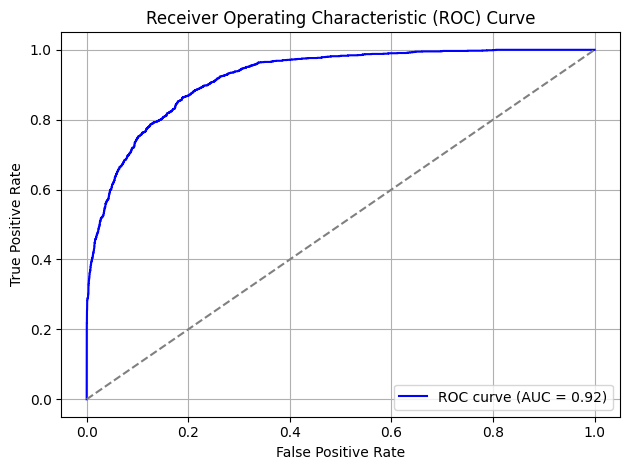

In [19]:
plot_roc_curve(
    fpr=result["fpr"],
    tpr=result["tpr"],
    roc_auc=result["roc_auc"],
    output_dir=".",
)

In [21]:
def plot_feature_importance(model, X, output_dir, max_features=10):
    """
    Plots feature importance for the model, showing the top N features.

    Parameters:
    - model: trained model with a `feature_importances_` attribute (e.g., RandomForest, XGBoost)
    - X: DataFrame or array, features used for training the model (to extract feature names)
    - output_dir: str, Directory to save the plot image
    - max_features: int, the number of top features to display (default is 10)

    Returns:
    - None
    """
    # Extract the trained model from the pipeline (if applicable)
    model = model.named_steps["model"] if hasattr(model, "named_steps") else model

    # Extract feature importances (if available)
    if hasattr(model, "feature_importances_"):
        importances = model.feature_importances_

        # Get feature names from the DataFrame if it has columns, or generate default names if ndarray
        feature_names = (
            X.columns
            if isinstance(X, pd.DataFrame)
            else [f"Feature {i}" for i in range(X.shape[1])]
        )

        # Create DataFrame to sort and plot feature importance
        importance_df = (
            pd.DataFrame({"Feature": feature_names, "Importance": importances})
            .sort_values(by="Importance", ascending=False)
            .head(max_features)
        )

        # Plot top feature importances
        plt.barh(
            importance_df["Feature"],
            importance_df["Importance"],
            color="purple",
        )
        plt.xlabel("Importance")
        plt.title(f"Top {max_features} Feature Importances")
        plt.gca().invert_yaxis()  # Display most important feature at the top

        # Automatically adjust the layout to make the plot compact
        plt.tight_layout()

        # Save the plot as an image file with high resolution
        if output_dir:
            feature_importance_file = os.path.join(output_dir, "feature_importance.png")
            plt.savefig(
                feature_importance_file, dpi=300
            )  # Save with high DPI for clarity
            print(f"Feature importance plot saved as {feature_importance_file}")

        # Show the plot (optional, can be skipped if you just want to save the plot)
        plt.show()

    else:
        print("No feature importance available for this model.")

    # Close the plot to free memory
    plt.close()

Feature importance plot saved as ./feature_importance.png


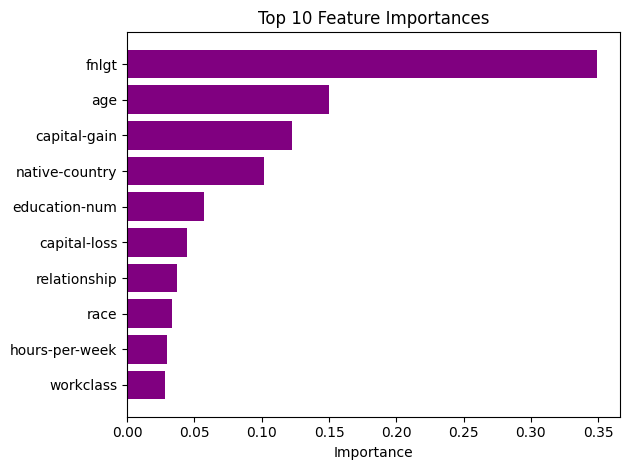

In [22]:
plot_feature_importance(best_model, X_val, ".", 10)

In [23]:
def save_model(model, output_dir):
    """
    Save the trained model to a .pkl file in the specified directory.
    """
    model_file = os.path.join(output_dir, "best_model.pkl")
    with open(model_file, "wb") as file:
        pickle.dump(model, file)
    print(f"Model saved as {model_file}")

In [24]:
def evaluate_model(
    y,
    Y_pred,
    Y_pred_prob,
    best_model,
    X,
    output_dir=".",
    set_name="Test Set",
    slice_evaluation_by_feature=True,
    categorical_features=["sex"],
):
    """
    Evaluates model performance and saves results, including metrics, plots, and the model itself, to the specified directory.

    Parameters:
    ----------
    y : array-like
        True labels or target values for the dataset (e.g., validation or test set).

    Y_pred : array-like
        Predicted labels (outputs from the model).

    Y_pred_prob : array-like
        Predicted probabilities from the model (for classification tasks).

    best_model : object
        The trained model (e.g., RandomForest, XGBoost) that was used to generate predictions.

    X : pd.DataFrame or np.ndarray
        Features used to train the model and to make predictions.

    output_dir : str, optional (default: ".")
        Directory where evaluation results (metrics, plots, model) will be saved.

    set_name : str, optional (default: "Test Set")
        A string representing the name of the dataset being evaluated (e.g., "Test Set" or "Validation Set").

    slice_evaluation_by_feature : bool, optional (default: True)
        If `True`, the model will be evaluated by slices of the categorical features (e.g., gender, age groups, etc.).

    categorical_features : list of str, optional (default: ['sex'])
        List of categorical features to evaluate the model slices by. This should be a list of column names in `X`.

    Returns:
    -------
    None
    """
    # Create the output directory if it doesn't exist
    os.makedirs(output_dir, exist_ok=True)

    # Print evaluation message
    print(f"Evaluating model performance for {set_name}...")

    # Compute evaluation metrics
    meta_evaluation = compute_model_metrics(y, Y_pred, Y_pred_prob, slice_display=False)

    # Extract evaluation metrics
    precision = meta_evaluation["precision"]
    recall = meta_evaluation["recall"]
    fbeta = meta_evaluation["fbeta"]
    fpr = meta_evaluation["fpr"]
    tpr = meta_evaluation["tpr"]
    roc_auc = meta_evaluation["roc_auc"]

    # Print metrics to console
    print(f"Precision: {precision}")
    print(f"Recall: {recall}")
    print(f"F-Beta: {fbeta}")
    print(f"ROC AUC: {roc_auc}")

    # Save the evaluation metrics to a CSV file
    logging.info("Saving evaluation metrics to CSV...")
    metrics_df = pd.DataFrame(
        {
            "Metric": ["Precision", "Recall", "F-Beta", "ROC AUC"],
            "Score": [precision, recall, fbeta, roc_auc],
        }
    )
    metrics_file = os.path.join(output_dir, "model_metrics.csv")
    metrics_df.to_csv(metrics_file, index=False)
    print(f"Metrics saved to {metrics_file}")

    # Plot and save the ROC Curve
    logging.info("Plotting and saving ROC Curve...")
    plot_roc_curve(fpr, tpr, roc_auc, output_dir)

    # Plot and save Feature Importance
    logging.info("Plotting and saving Feature Importance...")
    plot_feature_importance(best_model, X, output_dir, max_features=10)

    # Save the model as a .pkl file
    logging.info("Saving the trained model...")
    save_model(best_model.named_steps["model"], output_dir)

    # Evaluate the model by slices of categorical features (if applicable)
    if slice_evaluation_by_feature:
        logging.info("Evaluating by categorical features...")
        slice_compute_model_metrics(
            X, y, Y_pred, Y_pred_prob, categorical_features, output_dir
        )

    print(f"Model evaluation complete. Results saved to {output_dir}.")

2024-12-29 13:04:42,504 Saving evaluation metrics to CSV...
2024-12-29 13:04:42,507 Plotting and saving ROC Curve...


Evaluating model performance for Test Set...
Precision: 0.77
Recall: 0.64
F-Beta: 0.7
ROC AUC: 0.9216006002300094
Metrics saved to ./results/model_metrics.csv
ROC curve saved as ./results/roc_curve.png


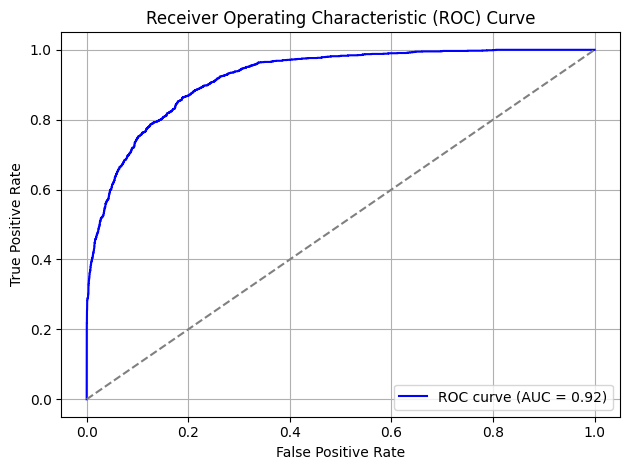

2024-12-29 13:04:42,841 Plotting and saving Feature Importance...


Feature importance plot saved as ./results/feature_importance.png


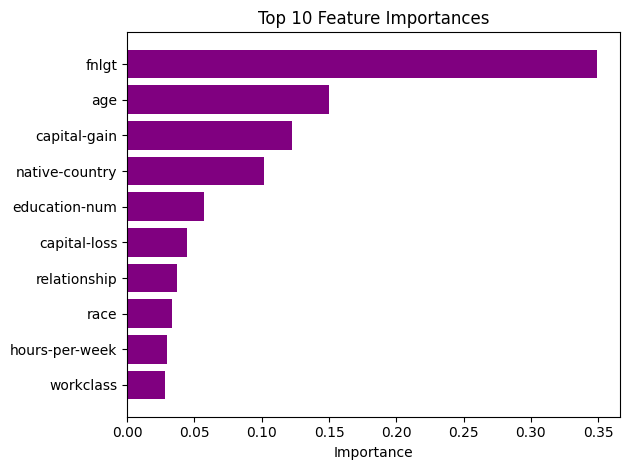

2024-12-29 13:04:43,139 Saving the trained model...
2024-12-29 13:04:43,144 Evaluating by categorical features...


Model saved as ./results/best_model.pkl
Model evaluation complete. Results saved to ./results.


In [25]:
evaluate_model(
    y_val,
    Y_test_pred,
    Y_test_pred_prob,
    best_model,
    X_val,
    output_dir="./results",
)